In [ ]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=48551a7f-906b-4a81-9cc2-e128cd895522
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:26<00:00, 55.8MB/s]


ZIP file opened successfully.
Extraction complete.
Using device: cuda


In [ ]:
# Define constants
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"  # Replace with the root directory of your data

# Create a list to store the paths and labels of all images
train_data = []
test_data = []

# Populate the list with paths and labels
for phase in data_dirs:
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            if phase == 'T4_Ptrain':
                train_data.append((image_path, label))
            else:
                test_data.append((image_path, label))

# Split train_data into training and validation sets while maintaining class distribution
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB mode
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return img, label_tensor

# Image preprocessing with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# Image preprocessing without augmentation for testing and validation
test_val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

# Create custom datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# DataLoaders for batching and shuffling
batch_size = 32  # Define the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the EfficientNet model
model = timm.create_model("efficientnet_b0", pretrained=True)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Modify the final layer to match the number of classes in the dataset
num_classes = len(data_dirs['T4_Ptrain'])
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

model.to(device)  # Move model to GPU

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)  # Set learning rate to 10^-3

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)  # Reduce factor, patience, and lower bound for LR

# Define loss function
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:

# Train the model
num_epochs = 100  # Set number of epochs to 100

# # Early stopping parameters
# early_stopping_patience = 15
# early_stopping_counter = 0
# best_val_loss = float('inf')

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        # Ensure the input tensor is passed correctly
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Adjust learning rate
    scheduler.step(val_loss)

    # # Early stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     early_stopping_counter = 0
    # else:
    #     early_stopping_counter += 1

    # if early_stopping_counter >= early_stopping_patience:
    #     print(f"Early stopping at epoch {epoch+1}")
    #     break


Epoch 1/100, Train Loss: 0.7736, Train Accuracy: 65.23%, Val Loss: 0.6462, Val Accuracy: 69.90%


Epoch 2/100, Train Loss: 0.5819, Train Accuracy: 74.68%, Val Loss: 0.6049, Val Accuracy: 75.32%


Epoch 3/100, Train Loss: 0.5155, Train Accuracy: 78.23%, Val Loss: 0.7044, Val Accuracy: 72.77%


Epoch 4/100, Train Loss: 0.4625, Train Accuracy: 80.42%, Val Loss: 0.5083, Val Accuracy: 79.62%


Epoch 5/100, Train Loss: 0.4155, Train Accuracy: 83.13%, Val Loss: 0.4722, Val Accuracy: 81.53%


Epoch 6/100, Train Loss: 0.3565, Train Accuracy: 85.81%, Val Loss: 0.5985, Val Accuracy: 74.68%


Epoch 7/100, Train Loss: 0.3403, Train Accuracy: 86.60%, Val Loss: 0.5053, Val Accuracy: 81.05%


Epoch 8/100, Train Loss: 0.3473, Train Accuracy: 85.85%, Val Loss: 0.7294, Val Accuracy: 72.45%


Epoch 9/100, Train Loss: 0.3270, Train Accuracy: 87.04%, Val Loss: 0.3846, Val Accuracy: 84.87%


Epoch 10/100, Train Loss: 0.3174, Train Accuracy: 87.04%, Val Loss: 0.4128, Val Accuracy: 82.32%


Epoch 11/100, Train Loss: 0.2470, Train Accuracy: 90.63%, Val Loss: 0.3937, Val Accuracy: 83.76%


Epoch 12/100, Train Loss: 0.2677, Train Accuracy: 90.27%, Val Loss: 0.5235, Val Accuracy: 78.98%


Epoch 13/100, Train Loss: 0.2691, Train Accuracy: 89.63%, Val Loss: 0.4234, Val Accuracy: 83.76%


Epoch 14/100, Train Loss: 0.2312, Train Accuracy: 91.07%, Val Loss: 0.4453, Val Accuracy: 82.32%


Epoch 15/100, Train Loss: 0.2366, Train Accuracy: 90.75%, Val Loss: 0.3753, Val Accuracy: 84.87%


Epoch 16/100, Train Loss: 0.2159, Train Accuracy: 91.71%, Val Loss: 0.4514, Val Accuracy: 85.03%


Epoch 17/100, Train Loss: 0.2047, Train Accuracy: 92.46%, Val Loss: 0.5150, Val Accuracy: 84.55%


Epoch 18/100, Train Loss: 0.2019, Train Accuracy: 92.22%, Val Loss: 0.3808, Val Accuracy: 87.10%


Epoch 19/100, Train Loss: 0.1733, Train Accuracy: 93.78%, Val Loss: 0.4339, Val Accuracy: 89.49%


Epoch 20/100, Train Loss: 0.1836, Train Accuracy: 93.58%, Val Loss: 0.4109, Val Accuracy: 86.31%


Epoch 21/100, Train Loss: 0.1753, Train Accuracy: 93.46%, Val Loss: 0.7055, Val Accuracy: 78.66%


Epoch 22/100, Train Loss: 0.2070, Train Accuracy: 92.70%, Val Loss: 0.4236, Val Accuracy: 86.31%


Epoch 23/100, Train Loss: 0.1646, Train Accuracy: 94.10%, Val Loss: 0.3886, Val Accuracy: 87.90%


Epoch 24/100, Train Loss: 0.1619, Train Accuracy: 94.18%, Val Loss: 0.4214, Val Accuracy: 85.03%


Epoch 25/100, Train Loss: 0.1236, Train Accuracy: 95.41%, Val Loss: 0.4895, Val Accuracy: 84.39%


Epoch 26/100, Train Loss: 0.1634, Train Accuracy: 93.34%, Val Loss: 0.4517, Val Accuracy: 85.03%


Epoch 27/100, Train Loss: 0.0966, Train Accuracy: 95.85%, Val Loss: 0.3562, Val Accuracy: 87.26%


Epoch 28/100, Train Loss: 0.0718, Train Accuracy: 97.37%, Val Loss: 0.3598, Val Accuracy: 87.10%


Epoch 29/100, Train Loss: 0.0615, Train Accuracy: 97.81%, Val Loss: 0.3535, Val Accuracy: 89.17%


Epoch 30/100, Train Loss: 0.0526, Train Accuracy: 97.89%, Val Loss: 0.3713, Val Accuracy: 88.06%


Epoch 31/100, Train Loss: 0.0429, Train Accuracy: 98.44%, Val Loss: 0.3581, Val Accuracy: 88.06%


Epoch 32/100, Train Loss: 0.0402, Train Accuracy: 98.72%, Val Loss: 0.3572, Val Accuracy: 88.38%


Epoch 33/100, Train Loss: 0.0448, Train Accuracy: 98.29%, Val Loss: 0.4133, Val Accuracy: 88.85%


Epoch 34/100, Train Loss: 0.0379, Train Accuracy: 98.84%, Val Loss: 0.3578, Val Accuracy: 89.49%


Epoch 35/100, Train Loss: 0.0314, Train Accuracy: 99.04%, Val Loss: 0.3950, Val Accuracy: 89.33%


Epoch 36/100, Train Loss: 0.0343, Train Accuracy: 99.00%, Val Loss: 0.3862, Val Accuracy: 88.54%


Epoch 37/100, Train Loss: 0.0264, Train Accuracy: 99.12%, Val Loss: 0.3688, Val Accuracy: 89.97%


Epoch 38/100, Train Loss: 0.0261, Train Accuracy: 99.28%, Val Loss: 0.4063, Val Accuracy: 89.33%


Epoch 39/100, Train Loss: 0.0338, Train Accuracy: 98.76%, Val Loss: 0.4228, Val Accuracy: 89.33%


Epoch 40/100, Train Loss: 0.0309, Train Accuracy: 98.84%, Val Loss: 0.3609, Val Accuracy: 89.65%


Epoch 41/100, Train Loss: 0.0242, Train Accuracy: 99.32%, Val Loss: 0.3580, Val Accuracy: 90.45%


Epoch 42/100, Train Loss: 0.0259, Train Accuracy: 99.08%, Val Loss: 0.3644, Val Accuracy: 90.13%


Epoch 43/100, Train Loss: 0.0360, Train Accuracy: 98.48%, Val Loss: 0.3510, Val Accuracy: 90.29%


Epoch 44/100, Train Loss: 0.0200, Train Accuracy: 99.40%, Val Loss: 0.3813, Val Accuracy: 90.29%


Epoch 45/100, Train Loss: 0.0227, Train Accuracy: 99.24%, Val Loss: 0.3753, Val Accuracy: 89.01%


Epoch 46/100, Train Loss: 0.0202, Train Accuracy: 99.24%, Val Loss: 0.3699, Val Accuracy: 90.61%


Epoch 47/100, Train Loss: 0.0232, Train Accuracy: 99.08%, Val Loss: 0.3734, Val Accuracy: 89.97%


Epoch 48/100, Train Loss: 0.0213, Train Accuracy: 99.24%, Val Loss: 0.3570, Val Accuracy: 90.13%


Epoch 49/100, Train Loss: 0.0252, Train Accuracy: 99.20%, Val Loss: 0.3708, Val Accuracy: 90.13%


Epoch 50/100, Train Loss: 0.0223, Train Accuracy: 99.12%, Val Loss: 0.3840, Val Accuracy: 89.49%


Epoch 51/100, Train Loss: 0.0251, Train Accuracy: 99.08%, Val Loss: 0.3809, Val Accuracy: 90.45%


Epoch 52/100, Train Loss: 0.0248, Train Accuracy: 99.08%, Val Loss: 0.3668, Val Accuracy: 90.29%


Epoch 53/100, Train Loss: 0.0247, Train Accuracy: 99.16%, Val Loss: 0.3539, Val Accuracy: 90.92%


Epoch 54/100, Train Loss: 0.0171, Train Accuracy: 99.48%, Val Loss: 0.3837, Val Accuracy: 89.81%


Epoch 55/100, Train Loss: 0.0208, Train Accuracy: 99.36%, Val Loss: 0.3659, Val Accuracy: 90.76%


Epoch 56/100, Train Loss: 0.0238, Train Accuracy: 99.12%, Val Loss: 0.3624, Val Accuracy: 89.81%


Epoch 57/100, Train Loss: 0.0182, Train Accuracy: 99.36%, Val Loss: 0.3787, Val Accuracy: 90.45%


Epoch 58/100, Train Loss: 0.0181, Train Accuracy: 99.32%, Val Loss: 0.3993, Val Accuracy: 88.85%


Epoch 59/100, Train Loss: 0.0215, Train Accuracy: 99.08%, Val Loss: 0.3593, Val Accuracy: 89.81%


Epoch 60/100, Train Loss: 0.0174, Train Accuracy: 99.48%, Val Loss: 0.3776, Val Accuracy: 90.13%


Epoch 61/100, Train Loss: 0.0185, Train Accuracy: 99.44%, Val Loss: 0.4023, Val Accuracy: 88.69%


Epoch 62/100, Train Loss: 0.0184, Train Accuracy: 99.40%, Val Loss: 0.3790, Val Accuracy: 89.01%


Epoch 63/100, Train Loss: 0.0184, Train Accuracy: 99.52%, Val Loss: 0.3839, Val Accuracy: 89.65%


Epoch 64/100, Train Loss: 0.0255, Train Accuracy: 99.04%, Val Loss: 0.3879, Val Accuracy: 90.45%


Epoch 65/100, Train Loss: 0.0214, Train Accuracy: 99.48%, Val Loss: 0.3621, Val Accuracy: 89.81%


Epoch 66/100, Train Loss: 0.0165, Train Accuracy: 99.44%, Val Loss: 0.3780, Val Accuracy: 89.33%


Epoch 67/100, Train Loss: 0.0223, Train Accuracy: 99.32%, Val Loss: 0.3761, Val Accuracy: 89.49%


Epoch 68/100, Train Loss: 0.0199, Train Accuracy: 99.36%, Val Loss: 0.3758, Val Accuracy: 89.01%


Epoch 69/100, Train Loss: 0.0197, Train Accuracy: 99.40%, Val Loss: 0.3654, Val Accuracy: 89.65%


Epoch 70/100, Train Loss: 0.0221, Train Accuracy: 99.24%, Val Loss: 0.3745, Val Accuracy: 90.61%


Epoch 71/100, Train Loss: 0.0205, Train Accuracy: 99.28%, Val Loss: 0.3704, Val Accuracy: 89.33%


Epoch 72/100, Train Loss: 0.0202, Train Accuracy: 99.44%, Val Loss: 0.3847, Val Accuracy: 89.49%


Epoch 73/100, Train Loss: 0.0239, Train Accuracy: 99.00%, Val Loss: 0.3748, Val Accuracy: 90.29%


Epoch 74/100, Train Loss: 0.0207, Train Accuracy: 99.36%, Val Loss: 0.3954, Val Accuracy: 88.69%


Epoch 75/100, Train Loss: 0.0243, Train Accuracy: 99.16%, Val Loss: 0.3875, Val Accuracy: 89.33%


Epoch 76/100, Train Loss: 0.0237, Train Accuracy: 99.12%, Val Loss: 0.3747, Val Accuracy: 91.24%


Epoch 77/100, Train Loss: 0.0217, Train Accuracy: 99.48%, Val Loss: 0.3894, Val Accuracy: 89.17%


Epoch 78/100, Train Loss: 0.0165, Train Accuracy: 99.48%, Val Loss: 0.3716, Val Accuracy: 90.76%


Epoch 79/100, Train Loss: 0.0227, Train Accuracy: 99.20%, Val Loss: 0.3694, Val Accuracy: 89.97%


Epoch 80/100, Train Loss: 0.0200, Train Accuracy: 99.40%, Val Loss: 0.3813, Val Accuracy: 88.69%


Epoch 81/100, Train Loss: 0.0199, Train Accuracy: 99.48%, Val Loss: 0.3828, Val Accuracy: 89.49%


Epoch 82/100, Train Loss: 0.0218, Train Accuracy: 99.32%, Val Loss: 0.3854, Val Accuracy: 89.17%


Epoch 83/100, Train Loss: 0.0172, Train Accuracy: 99.52%, Val Loss: 0.3653, Val Accuracy: 89.81%


Epoch 84/100, Train Loss: 0.0167, Train Accuracy: 99.48%, Val Loss: 0.3841, Val Accuracy: 89.65%


Epoch 85/100, Train Loss: 0.0182, Train Accuracy: 99.56%, Val Loss: 0.3709, Val Accuracy: 90.45%


Epoch 86/100, Train Loss: 0.0203, Train Accuracy: 99.40%, Val Loss: 0.3619, Val Accuracy: 89.81%


Epoch 87/100, Train Loss: 0.0157, Train Accuracy: 99.52%, Val Loss: 0.3786, Val Accuracy: 89.01%


Epoch 88/100, Train Loss: 0.0192, Train Accuracy: 99.36%, Val Loss: 0.3818, Val Accuracy: 89.65%


Epoch 89/100, Train Loss: 0.0193, Train Accuracy: 99.52%, Val Loss: 0.3939, Val Accuracy: 89.97%


Epoch 90/100, Train Loss: 0.0198, Train Accuracy: 99.40%, Val Loss: 0.3841, Val Accuracy: 89.65%


Epoch 91/100, Train Loss: 0.0181, Train Accuracy: 99.52%, Val Loss: 0.3785, Val Accuracy: 90.13%


Epoch 92/100, Train Loss: 0.0227, Train Accuracy: 99.16%, Val Loss: 0.3831, Val Accuracy: 89.49%


Epoch 93/100, Train Loss: 0.0194, Train Accuracy: 99.44%, Val Loss: 0.3847, Val Accuracy: 90.29%


Epoch 94/100, Train Loss: 0.0162, Train Accuracy: 99.48%, Val Loss: 0.3760, Val Accuracy: 89.97%


Epoch 95/100, Train Loss: 0.0198, Train Accuracy: 99.28%, Val Loss: 0.3709, Val Accuracy: 89.49%


Epoch 96/100, Train Loss: 0.0186, Train Accuracy: 99.36%, Val Loss: 0.3817, Val Accuracy: 89.97%


Epoch 97/100, Train Loss: 0.0192, Train Accuracy: 99.40%, Val Loss: 0.3654, Val Accuracy: 90.13%


Epoch 98/100, Train Loss: 0.0206, Train Accuracy: 99.32%, Val Loss: 0.3814, Val Accuracy: 89.65%


Epoch 99/100, Train Loss: 0.0176, Train Accuracy: 99.44%, Val Loss: 0.3977, Val Accuracy: 89.65%


Epoch 100/100, Train Loss: 0.0213, Train Accuracy: 99.28%, Val Loss: 0.3900, Val Accuracy: 89.33%


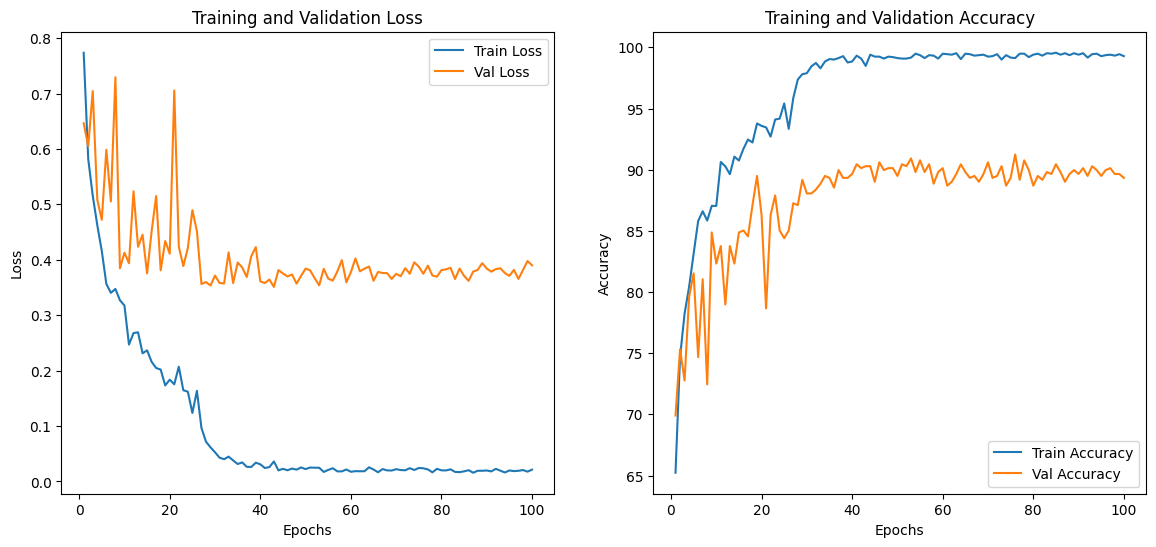

In [ ]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [ ]:

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)

# Generate classification report
true_labels = torch.tensor(true_labels).cpu().numpy()
predictions = torch.tensor(predictions).cpu().numpy()
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


Test Accuracy: 87.72%
              precision    recall  f1-score   support

     Class 0       0.76      0.86      0.80       118
     Class 1       0.95      0.88      0.91       187
     Class 2       0.89      0.88      0.88       322

    accuracy                           0.88       627
   macro avg       0.87      0.87      0.87       627
weighted avg       0.88      0.88      0.88       627



In [ ]:

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_recall_fscore_support
import numpy as np

# Assuming predictions and true_labels are already defined as numpy arrays
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) for each class
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Calculate metrics for each class
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

# Macro-averaged metrics
macro_recall = recall.mean()
macro_precision = precision.mean()
macro_f1_score = f1_score.mean()

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(cm)
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BCC): {balanced_accuracy:.3f}")


Confusion Matrix:
[[101   0  17]
 [  3 165  19]
 [ 29   9 284]]

Class-wise Metrics:
Class 0:
  TP: 101
  TN: 477
  FP: 32
  FN: 17
  Recall: 0.856
  Precision: 0.759
  F1-score: 0.805
Class 1:
  TP: 165
  TN: 431
  FP: 9
  FN: 22
  Recall: 0.882
  Precision: 0.948
  F1-score: 0.914
Class 2:
  TP: 284
  TN: 269
  FP: 36
  FN: 38
  Recall: 0.882
  Precision: 0.887
  F1-score: 0.885

Macro-averaged Metrics:
Macro Recall: 0.873
Macro Precision: 0.865
Macro F1-score: 0.868
Accuracy (ACC): 0.877
Balanced Accuracy (BCC): 0.873
